# Traitement Automatique de la Langue - TME2


## POS tagging, analyse des phrases



#### Chargement des données :

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def load(filename):
    listeDoc = list()
    with open(filename, "r") as f:
        doc = list()
        for ligne in f:
            #print "l : ",len(ligne)," ",ligne
            if len(ligne) < 2: # fin de doc
                listeDoc.append(doc)
                doc = list()
                continue
            mots = ligne.split(" ")
            doc.append((mots[0],mots[1]))
    return listeDoc



# =============== chargement ============
filename = "wapiti/chtrain.txt" 
filenameT = "wapiti/chtest.txt" 

alldocs = load(filename)
alldocsT = load(filenameT)

print len(alldocs)," docs read"
print len(alldocsT)," docs (T) read"

823  docs read
77  docs (T) read


## Approche à base de dictionnaire

In [3]:
dico = dict()
for doc in alldocs:
    for word in doc:
        dico[word[0]] = word[1] 


In [4]:
score = 0
total = 0
for doc in alldocsT:
    for word in doc:
        total+=1
        if dico.setdefault(word[0], 0) == word[1]:
            score += 1
print str(score)+' / '+str(total)
print str(float(score)*100/total)[0:4]+"% de réussite"

1433 / 1896
75.5% de réussite


## Méthodes séquentielles

In [5]:
# allx: liste de séquences d'observations
# allq: liste de séquences d'états
# N: nb états
# K: nb observation

def learnHMM(allx, allq, N, K, initTo1=True):
    if initTo1:
        eps = 1e-5
        A = np.ones((N,N))*eps
        B = np.ones((N,K))*eps
        Pi = np.ones(N)*eps
    else:
        A = np.zeros((N,N))
        B = np.zeros((N,K))
        Pi = np.zeros(N)
    for x,q in zip(allx,allq):
        Pi[int(q[0])] += 1
        for i in range(len(q)-1):
            A[int(q[i]),int(q[i+1])] += 1
            B[int(q[i]),int(x[i])] += 1
        B[int(q[-1]),int(x[-1])] += 1 # derniere transition
    A = A/np.maximum(A.sum(1).reshape(N,1),1) # normalisation
    B = B/np.maximum(B.sum(1).reshape(N,1),1) # normalisation
    Pi = Pi/Pi.sum()
    return Pi , A, B

def viterbi(x,Pi,A,B):
    T = len(x)
    N = len(Pi)
    logA = np.log(A)
    logB = np.log(B)
    logdelta = np.zeros((N,T))
    psi = np.zeros((N,T), dtype=int)
    S = np.zeros(T)
    logdelta[:,0] = np.log(Pi) + logB[:,x[0]]
    #forward
    for t in range(1,T):
        logdelta[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).max(0) + logB[:,x[t]]
        psi[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).argmax(0)
    # backward
    logp = logdelta[:,-1].max()
    S[T-1] = logdelta[:,-1].argmax()
    for i in range(2,T+1):
        S[T-i] = psi[S[T-i+1],T-i+1]
    return S, logp #, delta, psi
 

### Mise en forme des données

In [6]:
import numpy as np
# alldocs etant issu du chargement des données

buf = [[m for m,c in d ] for d in alldocs]

mots = []
[mots.extend(b) for b in buf]
mots = np.unique(np.array(mots))

nMots = len(mots)+1 # mot inconnu

mots2ind = dict(zip(mots,range(len(mots))))

mots2ind["UUUUUUUU"] = len(mots)

buf2 = [[c for m,c in d ] for d in alldocs]
cles = []
[cles.extend(b) for b in buf2]
cles = np.unique(np.array(cles))
cles2ind = dict(zip(cles,range(len(cles))))

nCles = len(cles)

print nMots,"words and",nCles,"keys in the dictionary"

# mise en forme des données
allx  = [[mots2ind[m] for m,c in d] for d in alldocs]
allxT = [[mots2ind.setdefault(m,len(mots)) for m,c in d] for d in alldocsT]

allq  = [[cles2ind[c] for m,c in d] for d in alldocs]
allqT = [[cles2ind.setdefault(c,len(cles)) for m,c in d] for d in alldocsT]

4570 words and 42 keys in the dictionary


## Application


In [7]:
pi,A,B = learnHMM(allx,allq,nCles,nMots)
s = [0 for i in range(len(allxT))]
l = [0 for i in range(len(allxT))]
for i in range(len(allxT)):
    s[i],l[i] = viterbi(allxT[i],pi,A,B)
score = 0
total = 0
for i in range(len(s)):
    
    for j in range(len(s[i])):
        total +=1
        
        if allqT[i][j] == s[i][j]:
            score+=1
print str(score)+' / '+str(total)
print str(float(score)*100/total)[0:4]+"% de réussite sur la base de test"            

1536 / 1896
81.0% de réussite sur la base de test


/home/melki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Matrice de transition A

<IPython.core.display.Javascript object>


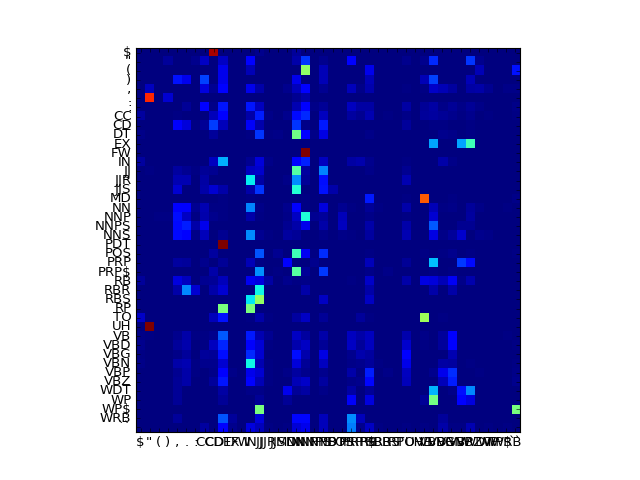

In [8]:
%matplotlib nbagg

plt.figure()
plt.imshow(A, interpolation='nearest')
plt.show()
localLabs = cles
plt.yticks(range(len(localLabs)),localLabs) # affichage sur l'image
plt.xticks(range(len(localLabs)),localLabs) # affichage sur l'image
 
plt.show()

### Matrice de confusion pour la HMM

In [9]:
conf = np.zeros((len(cles)+1,len(cles)+1))
for i in range(len(s)):
    for j in range(len(s[i])):
        if allqT[i][j] != s[i][j]:
            
            conf[allqT[i][j]][s[i][j]]+=1
            

/home/melki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


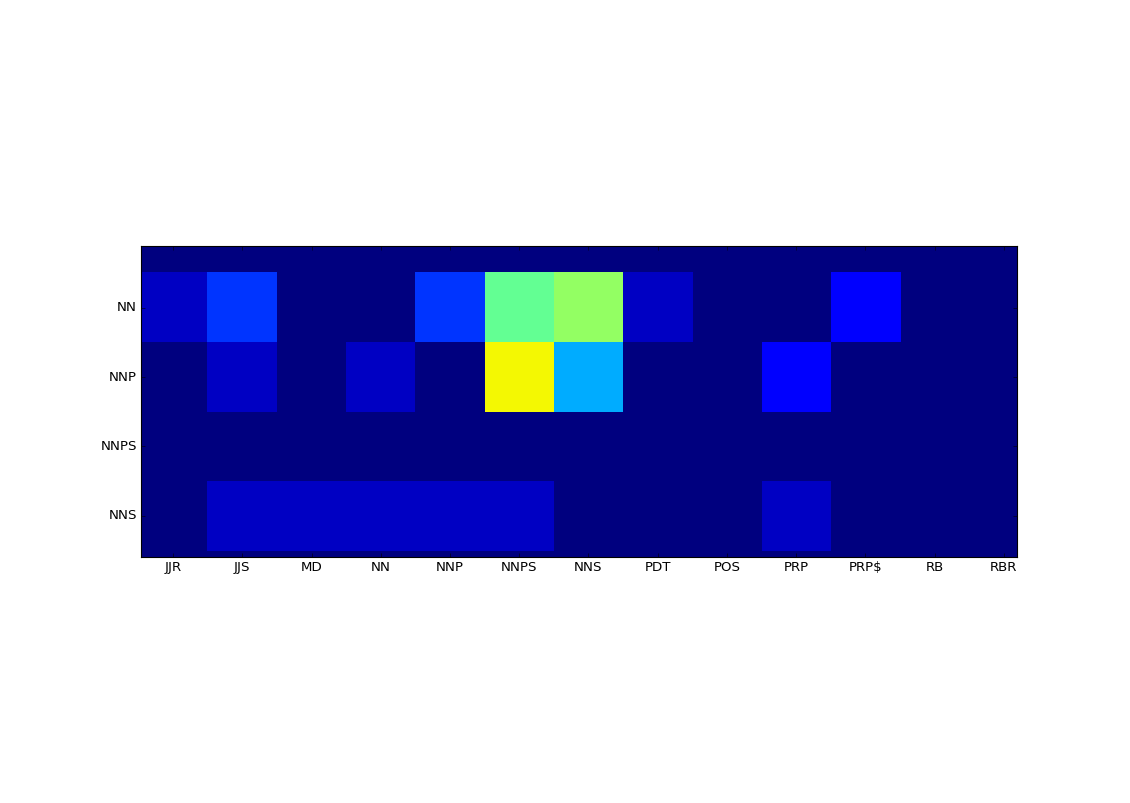

In [10]:
plt.figure()
plt.imshow(conf, interpolation='nearest')
plt.show()
localLabs = cles
plt.yticks(range(len(localLabs)),localLabs) # affichage sur l'image
plt.xticks(range(len(localLabs)),localLabs) # affichage sur l'image
 
plt.show()

### Matrice de confusion pour le dictionnaire

In [11]:
conf = np.zeros((len(cles)+1,len(cles)+1))
for doc in alldocsT:
    for word in doc:
        if dico.setdefault(word[0]) != word[1]:
            if dico.setdefault(word[0]) != 0:
                conf[np.where(cles==word[1])[0][0]][np.where(cles==dico.setdefault(word[0]))[0][0]]+=1
            


<IPython.core.display.Javascript object>


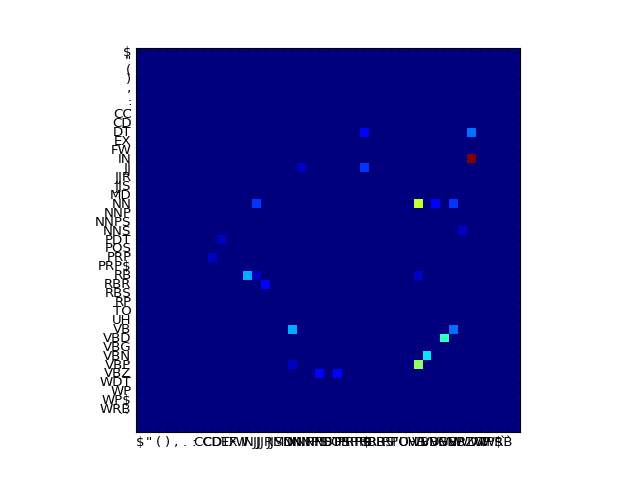

In [12]:
plt.figure()
plt.imshow(conf, interpolation='nearest')
plt.show()
localLabs = cles
plt.yticks(range(len(localLabs)),localLabs) # affichage sur l'image
plt.xticks(range(len(localLabs)),localLabs) # affichage sur l'image
 
plt.show()


### Modfile pour wapiti

In [18]:
f_doc=[w[0] for d in alldocsT for w in d]
f=open("chtest_wapiti.txt","w")
for w in f_doc:
    f.write(w+'\n')
f.close()

### Script pour comparer avec wapiti

In [ ]:
#open
wap=list()
with open("wapiti/chtrain.txt",'r') as f2:
    for line in f2:
        wap.append(line.split())
doc_mod=[w for d in alldocsT for w in d]
err=0
total=0
for i in range(len(doc_mod)):
    if(doc_mod[i][0]!=wap[i][0]):
        print 'Erreur!!'
    if(doc_mod[i][1]!=wap[i][1]):
        err+=1
    total+=1
print 'Taux de classif wapiti:'+str((1-float(err)/total)*100)+'%\n'

On trouve avec Wapiti un score bien supérieur à nos modèles : 95.99 % soit près de 15% supèrieur au modèle HMM et 20% supérieur au modèle naif.


Concernant les matrices de confusion on remarque sans surprise que ce sont les noms communs et propres qui posent le plus de problèmes (NN & NNP).
Les noms propres singuliers et pluriels sont souvent confondu avec la HMM. 


